# Imports

In [1]:
import karman
import torch
import pandas as pd
import os
import pickle
from karman.nn import SimpleNN


# Prepare data & model
See `get_started.ipynb` for more infos on this.

In [2]:
base_path='/'+os.getcwd().strip('docs/source/tutorials')

model_path=os.path.join(base_path,'tests/data/kml_model')
print('Loading Model')

model = SimpleNN().to(dtype=torch.float64)

state_dict = torch.load(os.path.join(model_path),map_location=torch.device('cpu'))['state_dict']
#Sanitize state_dict key names
for key in list(state_dict.keys()):
    if key.startswith('module'):
    # Model was saved as dataparallel model
        # Remove 'module.' from start of key
        state_dict[key[7:]] = state_dict.pop(key)
    else:
        continue
model.load_state_dict(state_dict)

Loading Model


/Users/ga00693/miniconda3/envs/karman/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [3]:
base_path='/'+os.getcwd().strip('docs/source/tutorials')
with open(os.path.join(base_path,'tests/data/thermo_scaler.pickle'), 'rb') as handle:
    thermo_scaler = pickle.load(handle)

with open(os.path.join(base_path,'tests/data/cyclical_feature_scaler.pickle'), 'rb') as handle:
    cyclical_feature_scaler = pickle.load(handle)

with open(os.path.join(base_path,'tests/data/thermospheric_density_scaler.pickle'), 'rb') as handle:
    thermospheric_density_scaler = pickle.load(handle)

In [4]:
features_to_exclude_thermo=['all__dates_datetime__',
                            'tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]',
                            'tudelft_thermo__satellite__',
                            'celestrack__ap_h_0__',
                            'celestrack__ap_h_1__',
                            'celestrack__ap_h_2__',
                            'celestrack__ap_h_3__',
                            'celestrack__ap_h_4__',
                            'celestrack__ap_h_5__',
                            'celestrack__ap_h_6__',
                            'celestrack__ap_average__',
                            'JB08__thermospheric_density__[kg/m**3]',
                            'NRLMSISE00__thermospheric_density__[kg/m**3]']

dataset_global=karman.ThermosphericDensityDataset(
    directory=os.path.join(base_path,'tests/data/globe_plot_data/'),
    features_to_exclude_thermo=features_to_exclude_thermo,
    create_cyclical_features=True,
    max_altitude=600000,
    thermo_scaler=thermo_scaler,
    cyclical_feature_scaler=cyclical_feature_scaler,
    thermospheric_density_scaler=thermospheric_density_scaler
)

Creating thermospheric density dataset
Creating cyclical features
['all__dates_datetime__', 'tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]', 'tudelft_thermo__satellite__', 'celestrack__ap_h_0__', 'celestrack__ap_h_1__', 'celestrack__ap_h_2__', 'celestrack__ap_h_3__', 'celestrack__ap_h_4__', 'celestrack__ap_h_5__', 'celestrack__ap_h_6__', 'celestrack__ap_average__', 'JB08__thermospheric_density__[kg/m**3]', 'NRLMSISE00__thermospheric_density__[kg/m**3]']
['all__day_of_year__[d]', 'all__seconds_in_day__[s]', 'all__sun_right_ascension__[rad]', 'all__sun_declination__[rad]', 'all__sidereal_time__[rad]', 'tudelft_thermo__longitude__[deg]', 'tudelft_thermo__local_solar_time__[h]']
Used features: Index(['all__year__[y]', 'tudelft_thermo__altitude__[m]',
       'tudelft_thermo__latitude__[deg]',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__f107_obs__',
       'space_environment_technologies__s107_obs__',
       'space_environm

In [5]:
dataset_global[0],len(dataset_global)

({'instantaneous_features': tensor([ 0.0000,  0.7550, -0.0054,  0.4842,  0.1535,  0.3455,  0.5253,  0.2231,
           0.5756,  0.4114,  0.7306,  0.0863,  0.7543,  0.9305,  0.5006,  1.0000,
           0.1395,  0.8464,  0.1249,  0.4480,  0.9969,  0.5560,  0.5000,  1.0000,
           0.4996,  1.0000], dtype=torch.float64),
  'target': tensor(0.7331, dtype=torch.float64)},
 1600)

# Dataloader and Karman-ML Model Predictions:

We first use the Pytorch DataLoader to wrap the Dataset (we use 400 as batch size, since the data only has 1,600 elements):

In [6]:
from torch.utils.data import DataLoader
dataloader_global=DataLoader(dataset_global,
                            batch_size=400,
                            num_workers=0,
                            drop_last=False)

Then, we apply the loaded Karman-ML thermospheric density model to predict thermospheric density over the dataset:

In [7]:
from tqdm import tqdm
model.eval()
with torch.no_grad():
    predictions=[]
    for batch in tqdm(dataloader_global):
        predictions.append(model(batch).squeeze().flatten())
    predictions=torch.stack(predictions).flatten()
    

100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 138.11it/s]


# Globe plot:

Finally, we prepare and plot the data on a globe grid

In [8]:
import numpy as np
num_points=40
longitude=np.linspace(-180,180,num_points)
latitude=np.linspace(-90,90,num_points)

lon_grid, lat_grid = np.meshgrid(longitude, latitude)


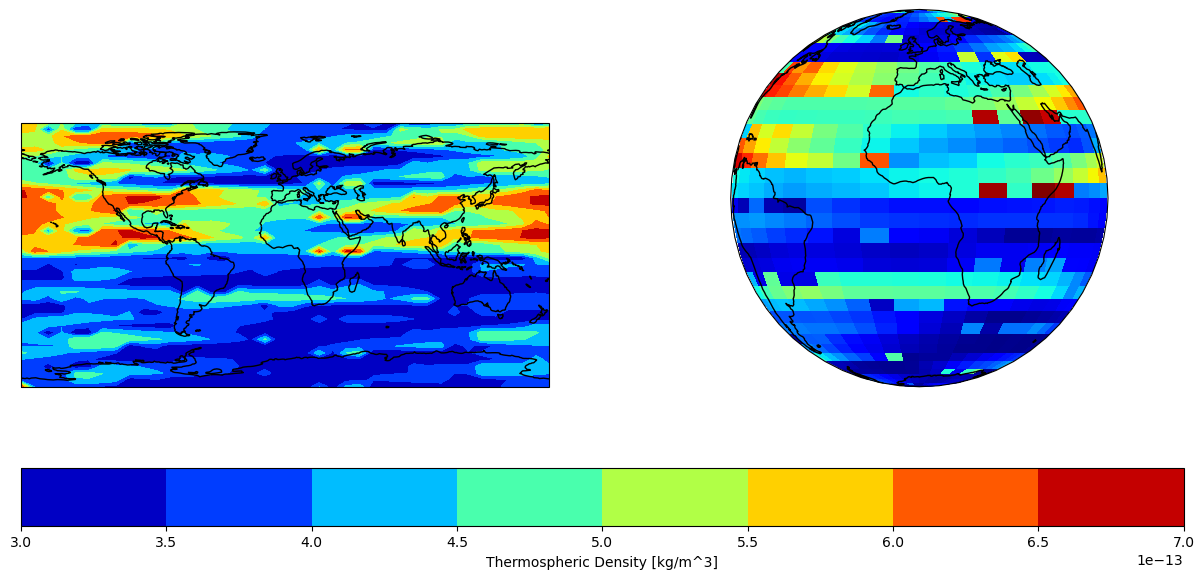

In [9]:
from karman import utils
utils.plot_global_density(dataset_global.unscale_density(predictions.numpy().reshape(lon_grid.shape)),longitude,latitude)